# Wine Classification using Gradient Boosting

In this notebook, we will use **Gradient Boosting** (As suggested by ChatGPT) to predict the type of wine based on chemical characteristics. 
<br>These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. 
<br>The analysis determined the quantities of 13 constituents found in each of the three types of wines. 
<br>Using this information, we try to predict from which cultivar the wine originates.

## Step 1: Data Loading and Inspection

We start by importing the packages that we will be using for our model and loading the wine dataset. 
<br>We use: 
    <br>`pandas` to analyze and prepare the data 
    <br>`scikit-learn` packages to apply the model and split the data into training and test data. We also use `GridSearchCV` to find the best parameters for the model.
    <br>`matplotlib/pyplot` and the confusion matrix from `scikit-learn` to visualize the data
    <br>
    <br>Note: For Gradient Boosting models, you usually don't need to scale or normalize the data, and it doesn’t make much difference in how well they perform. 
    <br>This is because these models use decision trees, which naturally work with different ranges of values without needing everything on the same scale.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay


In [14]:
wine_df = pd.read_csv('wine.csv')
wine_df.head()

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Now that we have loaded the data and taken a closer look at how the dataset is built up, we plot the distribution of a couple of variables in a scatter matrix.

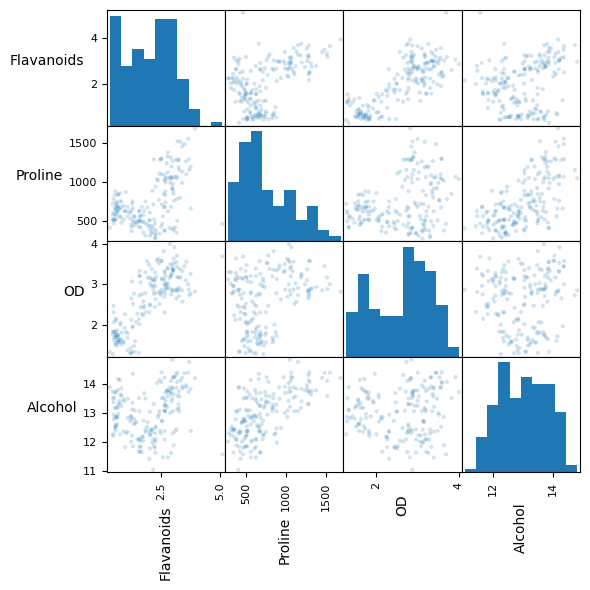

In [15]:
# Select the specified columns for the scatter matrix
selDF = wine_df[['Flavanoids', 'Proline', 'OD', 'Alcohol']]

# Plot the scatter matrix for these selected features
fig = pd.plotting.scatter_matrix(selDF, alpha=0.2, figsize=(6, 6), diagonal="hist")

# Rotate labels for better readability
for ax in fig.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha("right")

# Adjust layout and show the plot
plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()

The chart shows that wines with higher levels of flavanoids also tend to have higher OD values, which might help in telling wine types apart. 
<br>Proline levels are mostly low but vary widely, giving extra information that could help classify different wines.
<br>
<br>Next, we take a closer look at the types of wine and how many there are of each in our dataset.

In [16]:
cntWine = wine_df["Wine"].value_counts() # Counts how many of each wine is in the dataset
propWine = wine_df["Wine"].value_counts(normalize=True) # Counts the proportion of each wine in percentages
cntWine

Wine
2    71
1    59
3    48
Name: count, dtype: int64

In [17]:
propWine

Wine
2    0.398876
1    0.331461
3    0.269663
Name: proportion, dtype: float64

## Step 2: Data Preparation 
There are a few steps that need to be taken to prepare the data so that it can be given to the model.
<br>
First, we turn "Wine" into categories so that it tells the model to treat it as different wine types instead of numbers, helping it classify wines correctly.
<br>
<br>
Note: As stated before, we don't have to normalize the data because of the way Gradient Boosting works.

In [18]:
catType = pd.CategoricalDtype(categories=[1, 2, 3], ordered=False)
wine_df["Wine"] = wine_df["Wine"].astype(catType)
wine_df["Wine"]

0      1
1      1
2      1
3      1
4      1
      ..
173    3
174    3
175    3
176    3
177    3
Name: Wine, Length: 178, dtype: category
Categories (3, int64): [1, 2, 3]

## Step 3: Data Splitting
We split the data into training and testing sets to evaluate the performance of our model on unseen data.
<br>This split helps to ensure that the model generalizes well and avoids overfitting.
<br>`train_test_split` divides data into 80% training and 20% testing sets.
    

In [19]:

X = wine_df.drop('Wine', axis=1)  # Features
y = wine_df['Wine']               # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Step 4: Training the model
Now, we train the model using the training data.
<br>Then, we let it make predictions on the test set. 

In [20]:

# Initialize the model with default parameters
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

Next, we set up a grid search for tuning the hyperparameters of the Gradient Boosting model (gbc) to find the best combination for accuracy. 
<br>Below dictionary, param_grid, lists possible values for each hyperparameter:
<br>
<br>`n_estimators`: Number of trees in the ensemble (testing 100, 200, and 300).
<br>`learning_rate`: Controls how much each tree adjusts the model (testing values of 0.01, 0.1, and 0.2).
<br>`max_depth`: Maximum depth of each tree (3, 4, or 5 levels deep).
<br>`subsample`: Portion of the data used per tree (80% or 100% of the data).

In [21]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_gbc = grid_search.best_estimator_

Now, we use the best parameters on the test data and display it in a classification report and a confusion matrix:

In [22]:
y_pred = best_gbc.predict(X_test)
report = classification_report(y_test, y_pred)

print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00         8

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



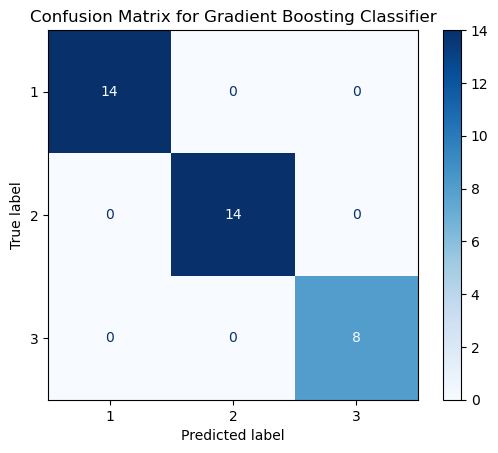

In [23]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gbc.classes_)

# Plot the confusion matrix
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Gradient Boosting Classifier")
plt.show()

In [24]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

1.0

The accuracy score of the Gradient Boost model on the test set is 100%. This means that the model correctly classified all of the test samples.
<br>
<br>Below is an overview of all the independent variables, and how important they are for determining the wine type:

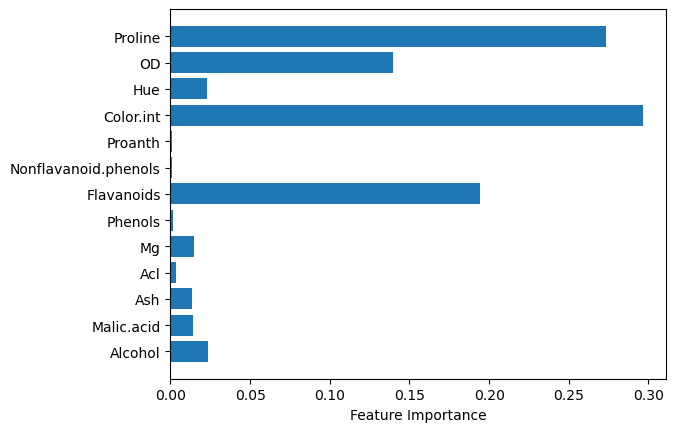

In [25]:
feature_importances = best_gbc.feature_importances_
plt.barh(X.columns, feature_importances)
plt.xlabel("Feature Importance")
plt.show()

# Conclusion
This notebook used Gradient Boosting to classify wines by their chemical traits, achieving high accuracy. 
<br>Key features, like flavanoids and proline, helped distinguish wine types. 
<br>The model worked well without extra data processing, scoring 100% on accuracy.
<br>This shows that Gradient Boosting could be effective for similar tasks in fields like food science. 
<br>While it scored 100% on this dataset, further tuning or exploring other models could improve results even more when another dataset is used.

# End of the Gradient Boosting Notebook.